In [1]:
import os
# Set the environment variable
#os.environ['STPSF_PATH'] = os.path.abspath("stpsf_data")
#os.environ['WEBBPSF_EXT_PATH'] = os.path.abspath("stpsf_data")
#os.environ['PYSYN_CDBS'] = os.path.abspath("webbpsf_ext_data/cdbs")
#os.environ['CRDS_PATH'] = os.path.abspath("crds_cache")
#os.environ['CRDS_SERVER_URL'] = "https://jwst-crds.stsci.edu"

# Verify the variable is set
print("STPSF_PATH:", os.environ['STPSF_PATH'])
print("WEBBPSF_EXT_PATH:", os.environ['WEBBPSF_EXT_PATH'])
print("PYSYN_CDBS:", os.environ['PYSYN_CDBS'])
print("CRDS_PATH:", os.environ['CRDS_PATH'])

STPSF_PATH: /home/yuchialin/JWST/stpsf_data
WEBBPSF_EXT_PATH: /home/yuchialin/JWST/stpsf_data
PYSYN_CDBS: /home/yuchialin/JWST/webbpsf_ext_data/cdbs
CRDS_PATH: /home/yuchialin/JWST/crds_cache


In [2]:
import os
import numpy as np
import subprocess

import spaceKLIP

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

import webbpsf_ext
webbpsf_ext.setup_logging('WARN', verbose=False)

In [3]:
data_root = 'data_nircam_twhya'

In [4]:
# Name the root directory where we will keep the data for this tutorial.
filt = 'F444W'  # Set to None to disable filter selection and load all filters.

In [10]:
# print out the header information for the science data
from astropy.io import fits
import glob

# Get science files that start with jw01179
sci_files = glob.glob(os.path.join(data_root, 'uncal', 'jw01179*_uncal.fits'))

if sci_files:
    print(f"Found {len(sci_files)} files starting with jw01179")
    print(f"Examining header of: {sci_files[0]}")
    print("="*80)
    for i in range(len(sci_files)):
        print(f"Processing file {i+1}/{len(sci_files)}: {sci_files[i]}")
        with fits.open(sci_files[i]) as hdul:
            primary_header = hdul[0].header
            actual_filter = primary_header.get('FILTER', 'UNKNOWN')
            print(f"FILTER INFORMATION: This data uses the {actual_filter} filter")
            # Key observation parameters that scientists typically need
            key_params = [
                ('TELESCOP', 'Telescope'),
                ('INSTRUME', 'Instrument'), 
                ('DETECTOR', 'Detector'),
                ('FILTER', 'Filter'),
                ('PUPIL', 'Pupil'),
                ('CORONMSK', 'Coronagraph Mask'),
                ('SUBARRAY', 'Subarray'),
                ('TARGPROP', 'Target Name'),
                ('TARG_RA', 'Target RA'),
                ('TARG_DEC', 'Target Dec'),
                ('DATE-OBS', 'Observation Date'),
                ('TIME-OBS', 'Observation Time'),
                ('EXPSTART', 'Exposure Start (MJD)'),
                ('EFFINTTM', 'Effective Integration Time (s)'),
                ('EFFEXPTM', 'Effective Exposure Time (s)'),
                ('DURATION', 'Total Duration (s)'),
                ('NINTS', 'Number of Integrations'),
                ('NGROUPS', 'Number of Groups'),
                ('NFRAMES', 'Number of Frames'),
                ('GROUPGAP', 'Group Gap')
            ]
            
            # Roll-related parameters (check multiple possible keywords)
            roll_params = [
                ('ROLL_REF', 'Roll Reference Angle (deg)'),
                ('PA_V3', 'V3 Position Angle (deg)'),
                ('ROLL', 'Roll Angle (deg)'),
                ('CRPIX1', 'Reference Pixel X'),
                ('CRPIX2', 'Reference Pixel Y'),
                ('PIXSCALE', 'Pixel Scale (arcsec/pixel)'),
                ('CRDS_VER', 'CRDS Version'),
                ('CRDS_CTX', 'CRDS Context')
            ]
            
            print("KEY OBSERVATION PARAMETERS:")
            print("="*80)
            print(f"{'Parameter':<15} {'Value':<25} {'Description'}")
            print("-"*80)
            
            for key, description in key_params:
                if key in primary_header:
                    value = primary_header[key]
                    print(f"{key:<15} {str(value):<25} {description}")
                else:
                    print(f"{key:<15} {'NOT FOUND':<25} {description}")
            
            print("\nROLL AND POINTING INFORMATION:")
            print("="*80)
            print(f"{'Parameter':<15} {'Value':<25} {'Description'}")
            print("-"*80)
            
            # Check primary header first
            for key, description in roll_params:
                if key in primary_header:
                    value = primary_header[key]
                    print(f"{key:<15} {str(value):<25} {description}")
                else:
                    print(f"{key:<15} {'NOT FOUND':<25} {description}")
            
            # Check if there are science extensions and look for roll info there
            if len(hdul) > 1:
                print(f"\nChecking extension headers for roll information...")
                for i in range(1, len(hdul)):
                    ext_header = hdul[i].header
                    found_roll_info = False
                    for key, description in roll_params:
                        if key in ext_header and key not in primary_header:
                            if not found_roll_info:
                                print(f"Extension {i}:")
                                found_roll_info = True
                            value = ext_header[key]
                            print(f"  {key:<13} {str(value):<25} {description}")
            
            print("\n" + "="*80)
        
else:
    print(f"No files starting with 'jw01179' found in {os.path.join(data_root, 'uncal')}")
    # Show what files are actually there
    all_files = glob.glob(os.path.join(data_root, 'uncal', '*_uncal.fits'))
    if all_files:
        print(f"Found {len(all_files)} total uncalibrated files:")
        for file in all_files[:5]:  # Show first 5 files
            filename = os.path.basename(file)
            print(f"  {filename}")
        if len(all_files) > 5:
            print(f"  ... and {len(all_files)-5} more files")
    else:
        print("No uncalibrated FITS files found in the directory")

Found 8 files starting with jw01179
Examining header of: data_nircam_twhya/uncal/jw01179005001_03106_00001_nrcalong_uncal.fits
Processing file 1/8: data_nircam_twhya/uncal/jw01179005001_03106_00001_nrcalong_uncal.fits
FILTER INFORMATION: This data uses the F356W filter
KEY OBSERVATION PARAMETERS:
Parameter       Value                     Description
--------------------------------------------------------------------------------
TELESCOP        JWST                      Telescope
INSTRUME        NIRCAM                    Instrument
DETECTOR        NRCALONG                  Detector
FILTER          F356W                     Filter
PUPIL           MASKRND                   Pupil
CORONMSK        MASKA335R                 Coronagraph Mask
SUBARRAY        SUB320A335R               Subarray
TARGPROP        TW-HYA                    Target Name
TARG_RA         165.4657150998156         Target RA
TARG_DEC        -34.70482446905551        Target Dec
DATE-OBS        2024-02-14                Obs

In [5]:
# Initialize spaceKLIP database.
database = spaceKLIP.database.create_database(
                                    input_dir=os.path.join(data_root, 'uncal'),
                                    output_dir=data_root,
                                    filt=filt,
                                    pid=None)

2025-07-28 07:59:21,885 - CRDS - INFO -  Calibration SW Found: jwst 1.17.1 (/home/yuchialin/miniconda3/envs/spaceklip/lib/python3.11/site-packages/jwst-1.17.1.dist-info)


[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
TYPE  EXP_TYPE DATAMODL TELESCOP ... PIXAR_SR BUNIT      ROLL_REF      BLURFWHM
---- --------- -------- -------- ... -------- ----- ------------------ --------
 SCI NRC_CORON   STAGE0     JWST ...      nan    DN  332.0778140709618      nan
 SCI NRC_CORON   STAGE0     JWST ...      nan    DN    342.07724058632      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN  72.65080814665343      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN  72.65080452089623      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN  72.65080693553715      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN   72.6508047694123      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN  72.65080445609345      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN 281.97771109232815      nan
 REF NRC_CORON   STAGE0     JWST ..

In [6]:
database.summarize()

NIRCAM_F444W_MASK335R
	STAGE0: 285 files;	2 SCI, 283 REF


In [7]:
# COMPREHENSIVE SUMMARY OF REFERENCE IMAGES AND STARS
print("="*60)
print("REFERENCE IMAGES AND STARS ANALYSIS")
print("="*60)

# Get the data
concat_key = 'JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R'
table = database.obs[concat_key]
df = table.to_pandas()

# Basic counts
total_ref = len(df[df['TYPE'] == 'REF'])
total_sci = len(df[df['TYPE'] == 'SCI'])

print(f"TOTAL IMAGES:")
print(f"  • Reference images: {total_ref}")
print(f"  • Science images: {total_sci}")
print(f"  • Total: {total_ref + total_sci}")
print()

# Reference star analysis
ref_df = df[df['TYPE'] == 'REF']
ref_star_counts = ref_df['TARGPROP'].value_counts()

print(f"REFERENCE STARS:")
print(f"  • Number of different reference stars: {len(ref_star_counts)}")
print(f"  • Reference star breakdown:")
for i, (star, count) in enumerate(ref_star_counts.items(), 1):
    percentage = (count/total_ref)*100
    print(f"    {i}. {star}: {count} images ({percentage:.1f}%)")
print()

# Science target
sci_df = df[df['TYPE'] == 'SCI']
sci_targets = sci_df['TARGPROP'].unique()
print(f"SCIENCE TARGET:")
print(f"  • Target name: {sci_targets[0]}")
print(f"  • Number of science images: {total_sci}")
print()

# Observation setup
print(f"OBSERVATION DETAILS:")
print(f"  • Filter: {df['FILTER'].iloc[0]}")
print(f"  • Coronagraph mask: {df['CORONMSK'].iloc[0]}")
print(f"  • Pupil mask: {df['PUPIL'].iloc[0]}")
print(f"  • Detector: {df['DETECTOR'].iloc[0]}")
print(f"  • Subarray: {df['SUBARRAY'].iloc[0]}")
print()

# Program IDs (from filenames)
ref_program_ids = set()
sci_program_ids = set()

for filename in ref_df['FITSFILE']:
    # Extract program ID from filename (format: jw[PROGRAM_ID]...)
    program_id = filename.split('/')[-1].split('_')[0][2:7]  # Remove 'jw' prefix
    ref_program_ids.add(program_id)

for filename in sci_df['FITSFILE']:
    program_id = filename.split('/')[-1].split('_')[0][2:7]
    sci_program_ids.add(program_id)

print(f"PROGRAM IDs:")
print(f"  • Reference observations from program(s): {', '.join(sorted(ref_program_ids))}")
print(f"  • Science observations from program(s): {', '.join(sorted(sci_program_ids))}")

print("="*60)

REFERENCE IMAGES AND STARS ANALYSIS
TOTAL IMAGES:
  • Reference images: 283
  • Science images: 2
  • Total: 285

REFERENCE STARS:
  • Number of different reference stars: 36
  • Reference star breakdown:
    1. HD_33093: 18 images (6.4%)
    2. -ups-Peg: 18 images (6.4%)
    3. REF-CD-23-9765: 14 images (4.9%)
    4. HD-61005-PSF: 10 images (3.5%)
    5. P330-E-OFFSET: 10 images (3.5%)
    6. HD114642: 10 images (3.5%)
    7. HD-35600: 10 images (3.5%)
    8. REF-IRAS-09432-4847: 9 images (3.2%)
    9. HD-30447-PSF: 9 images (3.2%)
    10. HD28343-F444W: 9 images (3.2%)
    11. V-AP-COL: 9 images (3.2%)
    12. HD-144002: 9 images (3.2%)
    13. REF-HD-89063: 9 images (3.2%)
    14. UCAC4_267-178509: 9 images (3.2%)
    15. HD25945: 9 images (3.2%)
    16. REF-Y-Crt: 9 images (3.2%)
    17. REF-HD-101581: 9 images (3.2%)
    18. REF-I-VEL: 9 images (3.2%)
    19. REF-IRAS-13041-5653: 9 images (3.2%)
    20. EPS-ERI-PSF-ALL: 5 images (1.8%)
    21. HD-32297-PSF: 5 images (1.8%)
    22.

In [ ]:
spaceKLIP.coron1pipeline.run_obs(database=database,
                       steps={'group_scale': {'skip': False},
                              'dq_init': {'skip': False},
                              'saturation': {'n_pix_grow_sat': 1,
                                             'grow_diagonal': False},
                              'ipc': {'skip': True},
                              'superbias':{'skip': False},
                              'refpix': {'odd_even_columns': True,
                                         'odd_even_rows': True,
                                         'nlower': 4,
                                         'nupper': 4,
                                         'nleft': 4,
                                         'nright': 4,
                                         'nrow_off': 0,
                                         'ncol_off': 0},
                              'linearity': {'skip': False},
                              'dark_current': {'skip': True},
                              'persistence': {'skip': True},
                              'jump': {'rejection_threshold': 4.,
                                       'three_group_rejection_threshold': 4.,
                                       'four_group_rejection_threshold': 4.,
                                       'maximum_cores': 'all'},
                              'subtract_1overf': {'model_type': 'savgol',
                                                  'sat_frac': 0.5,
                                                  'combine_ints': True,
                                                  'vertical_corr': True,
                                                  'nproc': 4},
                              'ramp_fit': {'save_calibrated_ramp': False,
                                          'maximum_cores': 'all'},
                              'gain_scale': {'skip': False}},
                       subdir='stage1')

[spaceKLIP.coron1pipeline:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw01179005001_03107_00001_nrcalong_uncal.fits
[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw01179008001_03107_00001_nrcalong_uncal.fits
[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw01193055001_05101_00001_nrcalong_uncal.fits


KeyboardInterrupt: 

In [ ]:
database.summarize()

NIRCAM_F444W_MASK335R
	STAGE0: 36 files;	2 SCI, 34 REF


In [ ]:
import spaceKLIP.__init__
print(spaceKLIP.__init__.__version__)

2.1.1.dev111+g6e5b1f9


In [ ]:
spaceKLIP.plotting.display_coron_dataset(
    database,
    restrict_to={
        'FILTER': filt,  # Sort by filter.
        'TYPE': ['SCI']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Static or interactive plots?
    zoom_center=3,  # Optional zoom factor; set to None to disable.
    vmin=0, vmax=1e3,  # Define the min/max values for consistent image scaling.
    save_filename='twhya_f444w_stage1.pdf'  # Save plots to PDF.
)

IntSlider(value=0, description='Image  Index:', max=1)

Output()

In [ ]:
database = spaceKLIP.database.create_database(
                                    input_dir=os.path.join(data_root, 'stage1'),
                                    file_type='rateints.fits',
                                    output_dir=data_root,
                                    filt=filt,
                                    pid=None)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
TYPE  EXP_TYPE DATAMODL TELESCOP ... PIXAR_SR BUNIT      ROLL_REF      BLURFWHM
---- --------- -------- -------- ... -------- ----- ------------------ --------
 SCI NRC_CORON   STAGE1     JWST ...      nan  DN/s  332.0778140709618      nan
 SCI NRC_CORON   STAGE1     JWST ...      nan  DN/s    342.07724058632      nan
 REF NRC_CORON   STAGE1     JWST ...      nan  DN/s  72.65080817676495      nan
 REF NRC_CORON   STAGE1     JWST ...      nan  DN/s  72.65080453008768      nan
 REF NRC_CORON   STAGE1     JWST ...      nan  DN/s  72.65080691738967      nan
 REF NRC_CORON   STAGE1     JWST ...      nan  DN/s   72.6508047395711      nan
 REF NRC_CORON   STAGE1     JWST ...      nan  DN/s   72.6508044401573      nan
 REF NRC_CORON   STAGE1     JWST ...      nan  DN/s   281.977711092322      nan
 REF NRC_CORON   STAGE1     JWST ..

In [ ]:
spaceKLIP.coron2pipeline.run_obs(database=database,
                                steps={'bkg_subtract': {'skip': False},
                                       'assign_wcs': {'skip': False},
                                       'flat_field': {'skip': False},
                                       'photom': {'skip': False},
                                       'outlier_detection': {'skip': False}},
                                subdir='stage2')

[spaceKLIP.coron2pipeline:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01179005001_03107_00001_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01179008001_03107_00001_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01193055001_05101_00001_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01193055001_05101_00002_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01193055001_05101_00003_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01193055001_05101_00004_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01193055001_05101_00005_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw02780011001_03109_00001_nrcal

In [ ]:
database.summarize()

NIRCAM_F444W_MASK335R
	STAGE2: 285 files;	2 SCI, 283 REF


In [ ]:
spaceKLIP.plotting.display_coron_dataset(
    database,
    restrict_to={
        'FILTER': filt,  # Sort by filter.
        'TYPE': ['SCI']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Static or interactive plots?
    zoom_center=3,  # Optional zoom factor; set to None to disable.
    vmin=0, vmax=1e3,  # Define the min/max values for consistent image scaling.
    save_filename='twhya_f444w_stage2.pdf'  # Save plots to PDF.
)

IntSlider(value=0, description='Image  Index:', max=1)

Output()

In [ ]:
database = spaceKLIP.database.create_database(
                                    input_dir=os.path.join(data_root, 'stage2'),
                                    file_type='calints.fits',
                                    output_dir=data_root,
                                    filt=filt,
                                    pid=None)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
TYPE  EXP_TYPE DATAMODL TELESCOP ... BUNIT       ROLL_REF      BLURFWHM
---- --------- -------- -------- ... ------ ------------------ --------
 SCI NRC_CORON   STAGE2     JWST ... MJy/sr  332.0778140709618      nan
 SCI NRC_CORON   STAGE2     JWST ... MJy/sr    342.07724058632      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr  72.65080817676495      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr  72.65080453008768      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr  72.65080691738967      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr   72.6508047395711      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr   72.6508044401573      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr   281.977711092322      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 281.97771729233693      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr

In [ ]:
# Initialize spaceKLIP image manipulation tools class.
imageTools = spaceKLIP.imagetools.ImageTools(database=database)


In [ ]:
# Median-subtract each frame to mitigate uncalibrated bias drifts.
imageTools.subtract_median(types=['SCI', 'SCI_TA', 'SCI_BG', 'REF', 'REF_TA', 'REF_BG'],
                           subdir='medsub')

[spaceKLIP.imagetools:INFO] Median subtraction using method=border
[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw01179005001_03107_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Median subtraction: mean of frame median = 0.06
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw01179008001_03107_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Median subtraction: mean of frame median = 0.06
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw01193055001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Median subtraction: mean of frame median = 0.97
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw01193055001_05101_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Median subtraction: mean of frame median = 0.94
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw01193055001_05101_00003_nrcalong_calint

In [ ]:
# Compare before and after median subtraction.

spaceKLIP.plotting.display_image_comparisons(
    database,
    ['stage2', 'medsub'],  # Subdirectories to look for files in.
    restrict_to={'FILTER': filt,  # Sort by filter.
                 'TYPE': ['SCI']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Static or interactive plots?
    vmin=0, vmax=10,  # Define the min/max values for consistent image scaling.
    save_filename='twhya_medsub_f444w_comparison.pdf')

IntSlider(value=0, description='Image Index:', max=1)

Output()

In [ ]:
# Fix bad pixels using custom spaceKLIP routines. Multiple routines can be
# combined in a custom order by joining them with a + sign.
# - sigclip: use sigma clipping to find additional bad pixels.
# - custom: use custom map to find additional bad pixels.
# - timemed: replace pixels which are only bad in some frames with their
#            median value from the good frames.
# - localmed: replace bad pixels with the median of surrounding good
#            pixels.
# - medfilt: replace bad pixels with an image plane median filter.

# - shift_x/y: Define the range of pixel shifts (left/right and up/down)
# used in sigma clipping to compare a pixel with its neighbors and identify deviations.

imageTools.fix_bad_pixels(method='sigclip+timemed+localmed+medfilt',
                          sigclip_kwargs={'sigclip': 3,
                                          'shift_x': [-3, 0, 3],
                                          'shift_y': [-3, 0, 3]},
                          custom_kwargs={},
                          timemed_kwargs={},
                          localmed_kwargs={'shift_x': [-1, 0, 1],
                                        'shift_y': [-1, 0, 1]},
                          medfilt_kwargs={'size': 4},
                          subdir='bpcleaned')

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Method sigclip: jw01179005001_03107_00001_nrcalong_calints.fits
Frame 16/16, iteration 5
[spaceKLIP.imagetools:INFO]   --> Method sigclip: identified 248020 additional bad pixel(s) -- 15.14%
[spaceKLIP.imagetools:INFO]   --> Method timemed: jw01179005001_03107_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method timemed: fixing 245559 bad pixel(s) -- 14.99%
[spaceKLIP.imagetools:INFO]   --> Method localmed: jw01179005001_03107_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method localmed: fixing 27600 bad pixel(s) -- 1.68%
[spaceKLIP.imagetools:INFO]   --> Method medfilt: jw01179005001_03107_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method medfilt: fixing 0 bad pixel(s) -- 0.00%
[spaceKLIP.imagetools:INFO]   --> Method sigclip: jw01179008001_03107_00001_nrcalong_calints.fits
Frame 16/16, iteration 5
[

In [ ]:
# Compare how well each cleaning method did to replace bad pixels.

spaceKLIP.plotting.display_image_comparisons(
    database,
    ['medsub', 'bpcleaned'],  # Subdirectories to look for files in.
    restrict_to={'FILTER': filt,  # Sort by filter.
                 'TYPE': ['SCI']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Static or interactive plots?
    vmin=0, vmax=10, # Define the min/max values for consistent image scaling.
    save_filename='twhya_clean_bp_f444w_comparison.pdf')

IntSlider(value=0, description='Image Index:', max=1)

Output()

In [ ]:
# This changes only the mask center information in the database table.
# No change in the observed data.
imageTools.update_nircam_centers()

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Update NIRCam coronagraphy centers: jw01179005001_03107_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Update NIRCam coronagraphy centers: using CRPIX from database
[spaceKLIP.imagetools:INFO]   --> Update NIRCam coronagraphy centers: old = (150.20, 174.60), new = (150.38, 174.39)
[spaceKLIP.imagetools:INFO]   --> Update NIRCam coronagraphy centers: jw01179008001_03107_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Update NIRCam coronagraphy centers: using CRPIX from database
[spaceKLIP.imagetools:INFO]   --> Update NIRCam coronagraphy centers: old = (150.20, 174.60), new = (150.38, 174.39)
[spaceKLIP.imagetools:INFO]   --> Update NIRCam coronagraphy centers: jw01193055001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Update NIRCam coronagraphy centers: using CRPIX from database
[spaceKLIP.imagetools:

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw01179005001_03107_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Recenter frames: generating WebbPSF image for absolute centering (this might take a while)
[spaceKLIP.psf:INFO] Generating on-axis and off-axis PSFs...
[spaceKLIP.psf:INFO]   Done.
[spaceKLIP.imagetools:INFO]   --> Recenter frames: star offset between frame 0 and coronagraph center (dx, dy) = (0.085, -0.010) pix
[spaceKLIP.imagetools:INFO]   --> Recenter frames: star offset between frame 1 and coronagraph center (dx, dy) = (0.074, -0.002) pix
[spaceKLIP.imagetools:INFO]   --> Recenter frames: star offset between frame 2 and coronagraph center (dx, dy) = (0.082, -0.023) pix
[spaceKLIP.imagetools:INFO]   --> Recenter frames: star offset between frame 3 and coronagraph center (dx, dy) = (0.071, -0.002) pix
[spaceKLIP.imagetools:INFO]   --> Recenter frames: s

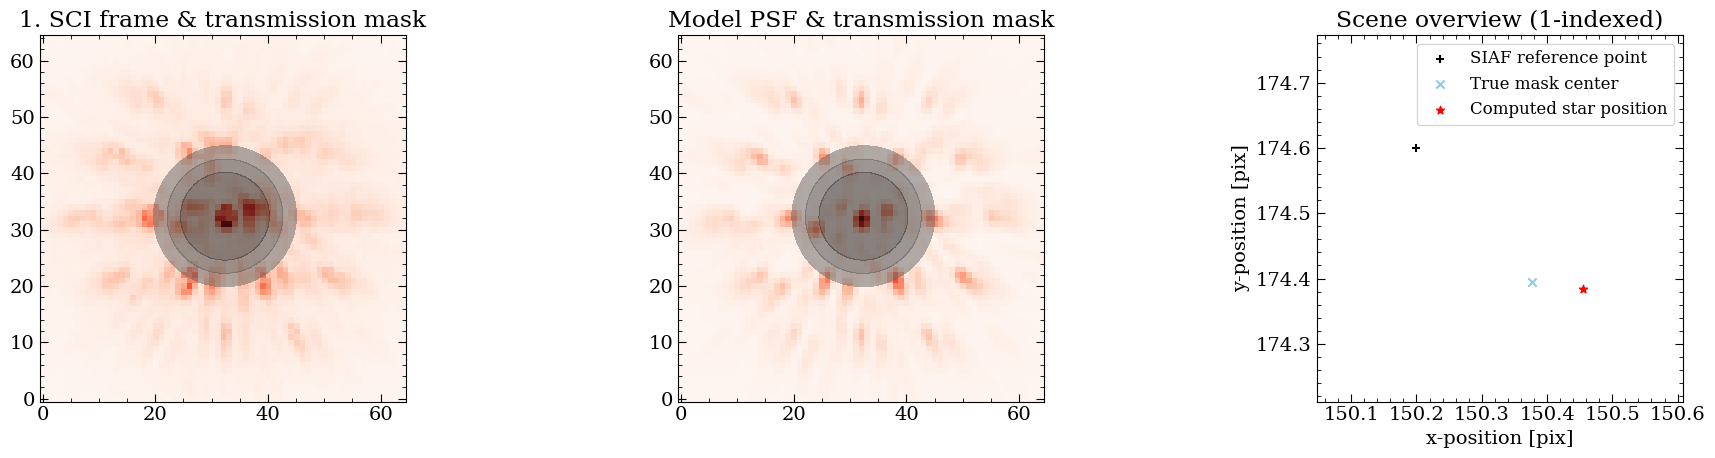

[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw01179005001_03107_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Recenter frames: median required shift = 1069.75 mas
[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw01179008001_03107_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw01179008001_03107_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Recenter frames: median required shift = 1069.75 mas
[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw01193055001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw01193055001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Recenter frames: median required shift = 1069.75 mas
[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw01193055001_05101_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw01193055001_05101_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Recenter fra

In [ ]:
imageTools.recenter_frames(spectral_type='M0V')

# The spectral type is used to make a more accurate PSF simulation for the star.
# This step changes the pixel data in the first science frame to center it.
# The other subsequent frames are shifted identically. I.e. the shift to center
# the first SCI frame is applied to all SCI and REF frames.

In [ ]:
!ls data_nircam_twhya/recentered/*pdf

data_nircam_twhya/recentered/jw01179005001_03107_00001_nrcalong_calints.pdf


[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Align frames: jw01179005001_03107_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 0.33 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw01179008001_03107_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 14.37 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw01193055001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 11.88 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw01193055001_05101_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 24.69 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw01193055001_05101_00003_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 36.56 mas
[spaceKLI

[spaceKLIP.imagetools:WARNING]   --> The following frames might not be properly aligned: [0 1 2]


[spaceKLIP.imagetools:INFO]   --> Align frames: jw02780022001_03109_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 434.07 mas


[spaceKLIP.imagetools:WARNING]   --> The following frames might not be properly aligned: [0 1 2]


[spaceKLIP.imagetools:INFO]   --> Align frames: jw02780022001_03109_00003_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 389.66 mas


[spaceKLIP.imagetools:WARNING]   --> The following frames might not be properly aligned: [0 1 2]


[spaceKLIP.imagetools:INFO]   --> Align frames: jw02780022001_03109_00004_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 417.59 mas


[spaceKLIP.imagetools:WARNING]   --> The following frames might not be properly aligned: [0 1 2]


[spaceKLIP.imagetools:INFO]   --> Align frames: jw02780022001_03109_00005_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 408.77 mas


[spaceKLIP.imagetools:WARNING]   --> The following frames might not be properly aligned: [0 1 2]


[spaceKLIP.imagetools:INFO]   --> Align frames: jw02780028001_03109_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 6.08 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw02780028001_03109_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 23.35 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw02780028001_03109_00003_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 9.68 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw02780028001_03109_00004_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 15.87 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw02780028001_03109_00005_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 20.09 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw02780031001_03109_00001_nrcalong_calints.fits
[spaceKLIP.image

[spaceKLIP.imagetools:WARNING]   --> The following frames might not be properly aligned: [0 1 2]


[spaceKLIP.imagetools:INFO]   --> Align frames: jw03947009001_03103_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 440.21 mas


[spaceKLIP.imagetools:WARNING]   --> The following frames might not be properly aligned: [0 1 2]


[spaceKLIP.imagetools:INFO]   --> Align frames: jw03947009001_03103_00003_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 432.15 mas


[spaceKLIP.imagetools:WARNING]   --> The following frames might not be properly aligned: [0 1 2]


[spaceKLIP.imagetools:INFO]   --> Align frames: jw03947009001_03103_00004_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 399.69 mas


[spaceKLIP.imagetools:WARNING]   --> The following frames might not be properly aligned: [0 1 2]


[spaceKLIP.imagetools:INFO]   --> Align frames: jw03947009001_03103_00005_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 405.90 mas


[spaceKLIP.imagetools:WARNING]   --> The following frames might not be properly aligned: [0 1 2]


[spaceKLIP.imagetools:INFO]   --> Align frames: jw03947012001_04103_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 17.69 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw03947012001_04103_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 18.03 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw03947012001_04103_00003_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 38.74 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw03947012001_04103_00004_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 34.88 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw03947012001_04103_00005_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 11.18 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw03947015001_03103_00001_nrcalong_calints.fits
[spaceKLIP.ima

[spaceKLIP.imagetools:WARNING]   --> The following frames might not be properly aligned: [0]


[spaceKLIP.imagetools:INFO]   --> Align frames: jw04498049001_0310l_00005_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 4.26 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw04558006001_03106_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 4.21 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw04558006001_03106_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 24.70 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw04558006001_03106_00003_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 22.95 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw04558006001_03106_00004_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 14.36 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw04558006001_03106_00005_nrcalong_calints.fits
[spaceKLIP.image

[spaceKLIP.imagetools:WARNING]   --> The following frames might not be properly aligned: [0]


[spaceKLIP.imagetools:INFO]   --> Align frames: jw06606011001_0310l_00003_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 11.03 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw06606011001_0310l_00004_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 23.76 mas
[spaceKLIP.imagetools:INFO]   --> Align frames: jw06606011001_0310l_00005_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Align frames: median required shift = 236.12 mas


[spaceKLIP.imagetools:WARNING]   --> The following frames might not be properly aligned: [0]


[spaceKLIP.imagetools:INFO]  Plot saved in data_nircam_twhya/aligned/JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R_align_sci.pdf


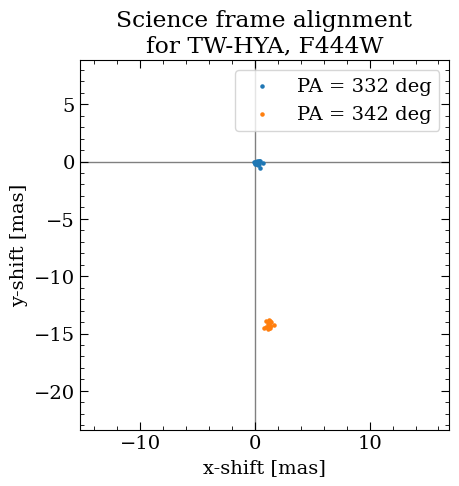

[spaceKLIP.imagetools:INFO]  Plot saved in data_nircam_twhya/aligned/JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R_align_ref.pdf


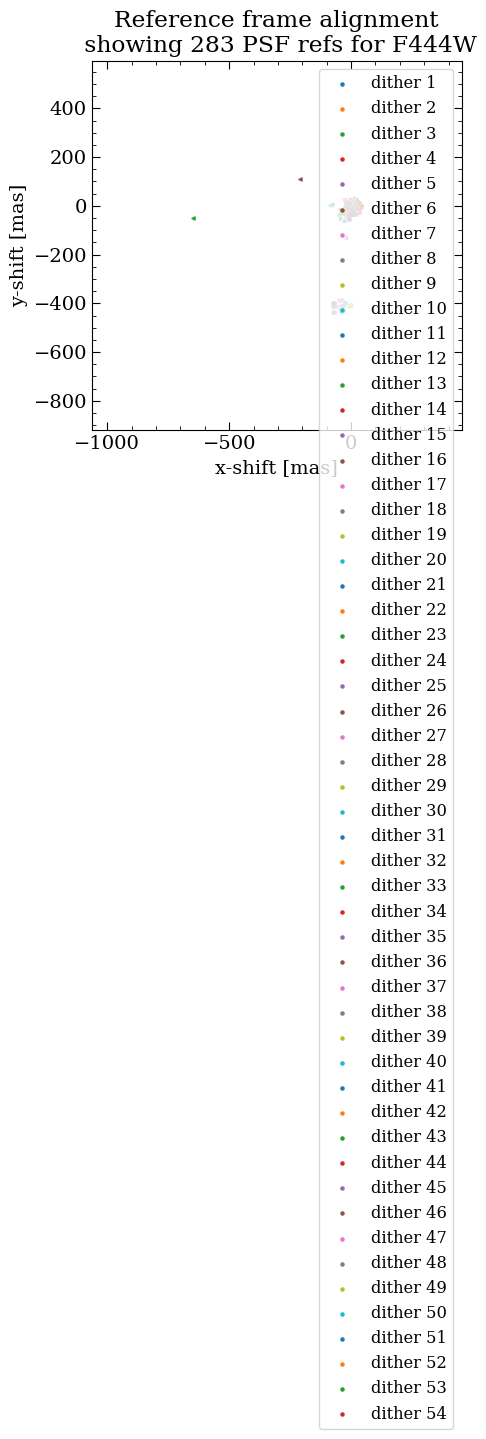

In [ ]:
# Align Frames Use image registration to align all frames in a concatenation to the
# first science frame in that concatenation.
imageTools.align_frames(method='fourier',
                        kwargs={},
                        subdir='aligned')

In [ ]:
# This step also outputs plots that show the results of the alignment.
!ls data_nircam_twhya/aligned/*pdf

data_nircam_twhya/aligned/JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R_align_ref.pdf
data_nircam_twhya/aligned/JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R_align_sci.pdf


In [ ]:
# Compare how well recentering and alignment did.

spaceKLIP.plotting.display_image_comparisons(
    database,
    ['recentered', 'aligned'],  # Subdirectories to look for files in.
    restrict_to={'FILTER': filt,  # Sort by filter.
                 'TYPE': ['SCI', 'REF']  # Sort by file type SCI/REF.
    },
    subtract_first=True,  # Subtract the first science frame to check alignment.
    interactive=True,  # Static or interactive plots?
    # Define the min/max/stretch values for consistent image scaling.
    # vmin=-0.5, vmax=0.5, stretch=0.05,
    save_filename='twhya_recenter_vs_align_f200W_comparison.pdf')

IntSlider(value=1, description='Image Index:', max=284, min=1)

Output()

In [ ]:
# Pad all frames.
imageTools.pad_frames(npix=80,
                      cval=np.nan,
                      types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                      subdir='padded')

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw01179005001_03107_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame padding: old shape = (320, 320), new shape = (480, 480), fill value = nan
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw01179008001_03107_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame padding: old shape = (320, 320), new shape = (480, 480), fill value = nan
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw01193055001_05101_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame padding: old shape = (320, 320), new shape = (480, 480), fill value = nan
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw01193055001_05101_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame padding: old shape = (320, 320), new shape = (480, 480), fill value = nan
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw011

In [ ]:
spaceKLIP.plotting.display_coron_dataset(
    database,
    restrict_to={'FILTER': filt,  # Sort by filter.
                 'TYPE': ['SCI']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Set to False for static plots.
    zoom_center=3,  # Optional zoom factor; set to None to disable.
    bbox_color=None,  # Remove background text boxes.
    save_filename='twhya_f444w_stage2_cleaned.pdf'  # Save plots to PDF.
)

IntSlider(value=0, description='Image  Index:', max=1)

Output()

In [ ]:
# Run pyKLIP pipeline. Additional parameters for klip_dataset function can
# be passed using kwargs parameter.
spaceKLIP.pyklippipeline.run_obs(database=database,
                       kwargs={'mode': ['ADI', 'RDI', 'ADI+RDI'],
                               'annuli': [1],
                               'subsections': [1],
                               'numbasis': [1, 2, 5, 10, 20, 50],
                               'algo': 'klip',
                               'save_rolls': True},
                       subdir='klipsub')

[spaceKLIP.pyklippipeline:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.pyklippipeline:INFO]   --> pyKLIP: mode = ADI, annuli = 1, subsections = 1
Begin align and scale images for each wavelength
Wavelength 4.439e-06 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /home/yuchialin/JWST/twhya/444W/data_nircam_twhya/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(6, 32, 1, 480, 480)
[spaceKLIP.pyklippipeline:INFO]   --> pyKLIP: mode = RDI, annuli = 1, subsections = 1
Begin align and scale images for each wavelength
Wavelength 4.439e-06 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /home/yuchialin/JWST/twhya/444W/data_nircam_twhya/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(6, 32, 1, 480, 480)
[spaceKLIP.pyklippipeline:INFO]   --> pyKLIP: mode = ADI+RDI, annuli = 1, subsections = 1
Begin align and scale images for each wavelength
Wavelength 4.439e-06 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /home/yuchialin/JWST/twhya/444W/data_nircam_twhya/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(6, 32, 1, 480, 480)
[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
 TYPE   EXP_TYPE DATAMODL TELESCOP ... SUBSECTS    KLMODES     BUNIT  BLURFWHM
------ --------- -------- -------- ... -------- -------------- ------ --------
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan


In [ ]:
database.summarize()

NIRCAM_F444W_MASK335R
	STAGE2: 285 files;	2 SCI, 283 REF
	STAGE3: 3 files;	3 PYKLIP


In [ ]:
database = spaceKLIP.database.create_database(
                                    input_dir=os.path.join(data_root, 'klipsub'),
                                    file_type='*KLmodes-all.fits',
                                    output_dir=data_root,
                                    readlevel=3,
                                    pid=1179)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
 TYPE   EXP_TYPE DATAMODL TELESCOP ... SUBSECTS    KLMODES     BUNIT  BLURFWHM
------ --------- -------- -------- ... -------- -------------- ------ --------
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan


In [ ]:
database.summarize()

NIRCAM_F444W_MASK335R
	STAGE2: 285 files;	2 SCI, 283 REF
	STAGE3: 3 files;	3 PYKLIP


In [ ]:
# show the image in PYKLIP output
spaceKLIP.plotting.display_coron_dataset(
    database,
    interactive=False,  # Static or interactive plots?
    zoom_center=3,  # Optional zoom factor; set to None to disable.
    vmin=0, vmax=1e3,  # Define the min/max values for consistent image scaling.
    save_filename='twhya_f444w_klipsub.pdf'  # Save plots to PDF.
)

RuntimeError: Display code does not support stage 0 uncal files. Reduce the data further before trying to display it.

# Post-pipeline

In [ ]:
import os
import glob
import numpy as np
import astropy
import astropy.table
import matplotlib.pyplot as plt
import spaceKLIP
import webbpsf_ext
webbpsf_ext.setup_logging('WARN', verbose=False)
# Name the root directory where we will keep the data for this tutorial.
data_root = 'data_nircam_twhya'
filt = 'F444W'  # Set to None to disable filter selection and load all filters.

In [ ]:
# Define the directory containing the KLIP output files.
input_dir = os.path.join(data_root, 'klipsub')

# Get a sorted list of FITS files that match the filter and KLmodes pattern.
fitsfiles = sorted(glob.glob(os.path.join(input_dir, f"*{filt}*KLmodes-all.fits")))

# Initialize the SpaceKLIP database with the root data directory.
database = spaceKLIP.database.Database(output_dir=data_root)

# Read the JWST data from the FITS files into the database.
database.read_jwst_s3_data(fitsfiles)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)


[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
 TYPE   EXP_TYPE DATAMODL TELESCOP ... SUBSECTS    KLMODES     BUNIT  BLURFWHM
------ --------- -------- -------- ... -------- -------------- ------ --------
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan


In [ ]:
star_photometry_vot = 'twhya.vot'  # VOTable.
star_spectral_type = 'M0V'  # Spectral type.

In [ ]:
# Read in the VOTable version of the star photometry data.
vot_version = astropy.table.Table.read(star_photometry_vot)

# Convert frequency to wavelength (microns) for plotting.
vot_version["wavelength"] = (astropy.constants.c / vot_version["sed_freq"]).to(
    astropy.units.micron)

print("VOTable Version of Star Photometry Data:")
vot_version.to_pandas()  # For an easier to read output.

VOTable Version of Star Photometry Data:


,_RAJ2000,_DEJ2000,_tabname,_ID,sed_freq,sed_flux,sed_eflux,sed_filter,wavelength
0,165.466277,-34.704728,I/239/hip_main,recno=53870,541430.0,0.1560,NaN,Johnson:V,0.553705
1,165.466277,-34.704728,I/239/hip_main,recno=53870,563630.0,0.1300,0.0140,HIP:VT,0.531896
2,165.466277,-34.704728,I/239/hip_main,recno=53870,713280.0,0.0656,0.0079,HIP:BT,0.420301
3,165.466277,-34.704728,I/239/hip_main,recno=53870,745750.0,0.1400,0.0050,HIP:Hp,0.402001
4,165.466341,-34.704643,I/239/tyc_main,recno=749379,541430.0,0.1350,NaN,Johnson:V,0.553705
...,...,...,...,...,...,...,...,...,...
453,165.466272,-34.704731,J/MNRAS/491/215/table1,recno=73,445460.0,0.2010,NaN,Gaia:G,0.672995
454,165.466292,-34.704722,J/MNRAS/494/2429/table1,recno=75,138550.0,0.8140,0.0180,2MASS:Ks,2.163785
455,165.466292,-34.704722,J/MNRAS/494/2429/table1,recno=75,445460.0,0.2010,0.0010,Gaia:G,0.672995
456,165.465903,-34.704793,J/MNRAS/529/1802/targets,recno=719177,445460.0,0.1990,NaN,Gaia:G,0.672995


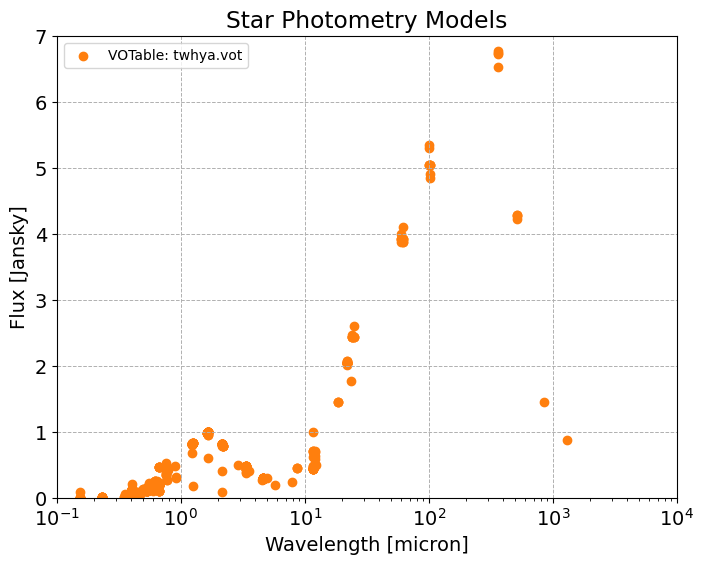

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(
    vot_version["wavelength"],
    vot_version["sed_flux"],
    label="VOTable: twhya.vot",
    color="C1",
)

plt.xlabel("Wavelength [micron]")
plt.ylabel("Flux [Jansky]")
plt.legend(fontsize=10)

plt.xscale("log")
plt.xlim(0.1, 10**4)
plt.ylim(0, 7)
plt.grid(True, linestyle="--", linewidth=0.7)
plt.title("Star Photometry Models")

plt.show()

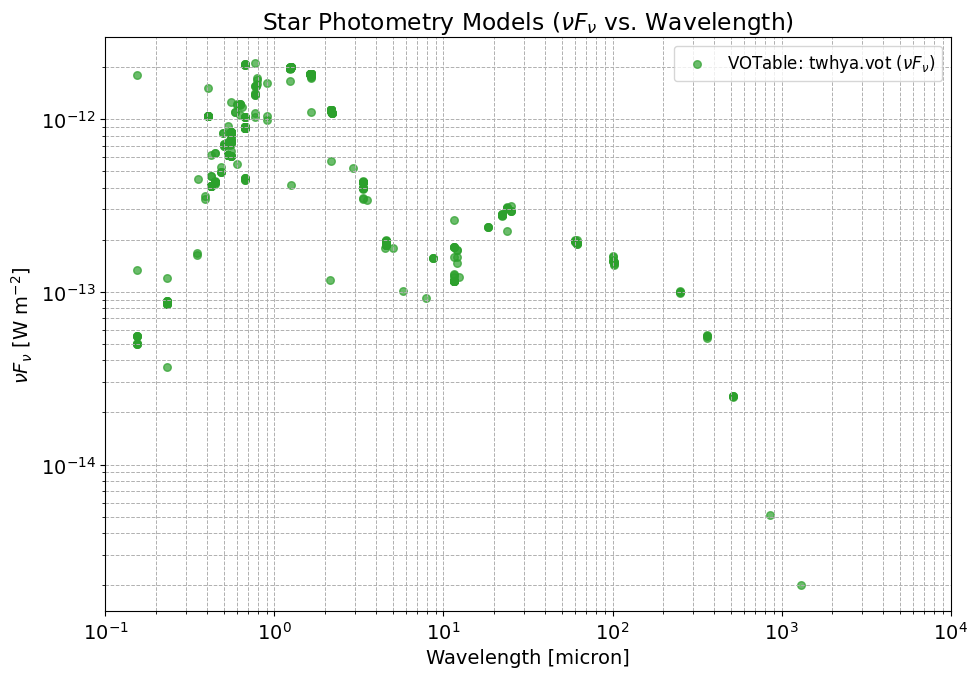

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Constants

c = 299792458.0  # Speed of light in m/s
Jy_to_Wm2Hz = 1e-26  # Conversion factor for Jansky to W/m^-2/Hz^-1
micron_to_m = 1e-6   # Conversion factor for micron to m

# Extract data from your vot_version
wavelength_microns = vot_version["wavelength"]
sed_flux_jansky = vot_version["sed_flux"]

# 1. Convert wavelength from microns to meters
wavelength_m = wavelength_microns * micron_to_m

# 2. Calculate frequency (nu) in Hz
frequency_hz = c / wavelength_m # Simpler, assuming valid wavelengths

# 3. Convert flux density F_nu from Jansky to W/m^2/Hz
sed_flux_Wm2Hz = sed_flux_jansky * Jy_to_Wm2Hz

# 4. Calculate nu * F_nu in W/m^2
nu_F_nu_Wm2 = frequency_hz * sed_flux_Wm2Hz

# --- Plotting ---
plt.figure(figsize=(10, 7)) # Slightly larger for better readability
plt.scatter(
    wavelength_microns, # X-axis remains wavelength in microns
    nu_F_nu_Wm2,
    label=r"VOTable: twhya.vot ($\nu F_{\nu}$)", # Use LaTeX for nu F_nu
    color="C2", # Changed color for distinction if you plot both
    s=30,       # Marker size
    alpha=0.7   # Marker transparency
)

plt.xlabel("Wavelength [micron]")
plt.ylabel(r"$\nu F_{\nu}$ [W m$^{-2}$]") # LaTeX for units
plt.legend(fontsize=12)

plt.xscale("log")
plt.yscale("log")

plt.xlim(0.1, 10**4)
plt.grid(True, linestyle="--", linewidth=0.7, which="both") # 'which="both"' is good for log scales
plt.title(r"Star Photometry Models ($\nu F_{\nu}$ vs. Wavelength)")

plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.show()

In [ ]:
# Initialize the spaceKLIP contrast estimation class.
analysistools = spaceKLIP.analysistools.AnalysisTools(database)

[spaceKLIP.analysistools:INFO] Copying starfile twhya.vot to data_nircam_twhya/rawcon/twhya.vot
[spaceKLIP.analysistools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_twhya/klipsub/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.psf:INFO]   --> Generating WebbPSF model
[spaceKLIP.analysistools:INFO]   Measuring raw contrast in annuli
[spaceKLIP.analysistools:INFO]   Measuring raw contrast for masked data
[spaceKLIP.analysistools:INFO]  Plot saved in data_nircam_twhya/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_masked.pdf


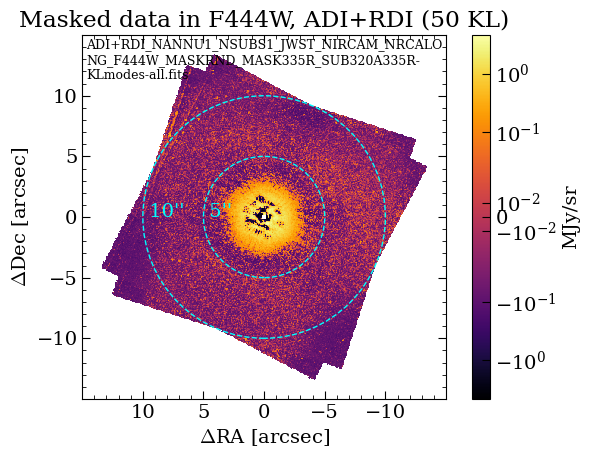

[spaceKLIP.analysistools:INFO]  Plot saved in data_nircam_twhya/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_rawcon.pdf


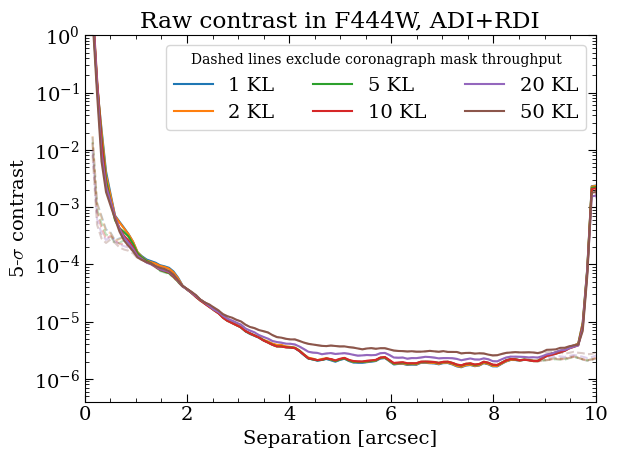

Contrast results and plots saved to data_nircam_twhya/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy, data_nircam_twhya/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy
[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_twhya/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.psf:INFO]   --> Generating WebbPSF model
[spaceKLIP.analysistools:INFO]   Measuring raw contrast in annuli
[spaceKLIP.analysistools:INFO]   Measuring raw contrast for masked data
[spaceKLIP.analysistools:INFO]  Plot saved in data_nircam_twhya/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_masked.pdf


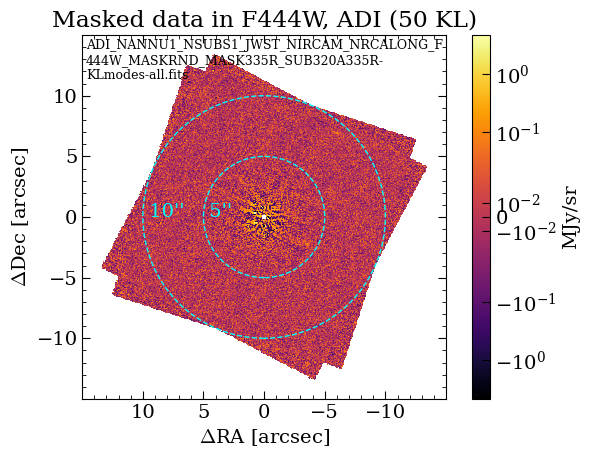

[spaceKLIP.analysistools:INFO]  Plot saved in data_nircam_twhya/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_rawcon.pdf


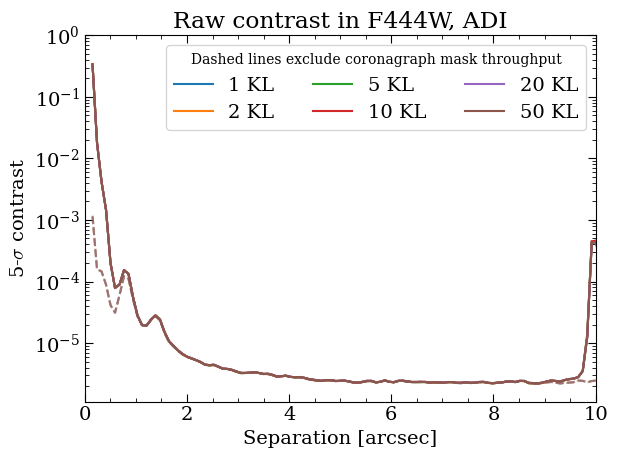

Contrast results and plots saved to data_nircam_twhya/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy, data_nircam_twhya/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy
[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_twhya/klipsub/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.psf:INFO]   --> Generating WebbPSF model
[spaceKLIP.analysistools:INFO]   Measuring raw contrast in annuli
[spaceKLIP.analysistools:INFO]   Measuring raw contrast for masked data
[spaceKLIP.analysistools:INFO]  Plot saved in data_nircam_twhya/rawcon/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_masked.pdf


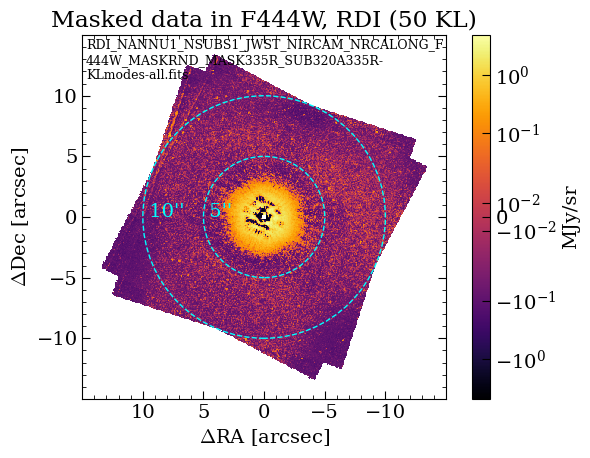

[spaceKLIP.analysistools:INFO]  Plot saved in data_nircam_twhya/rawcon/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_rawcon.pdf


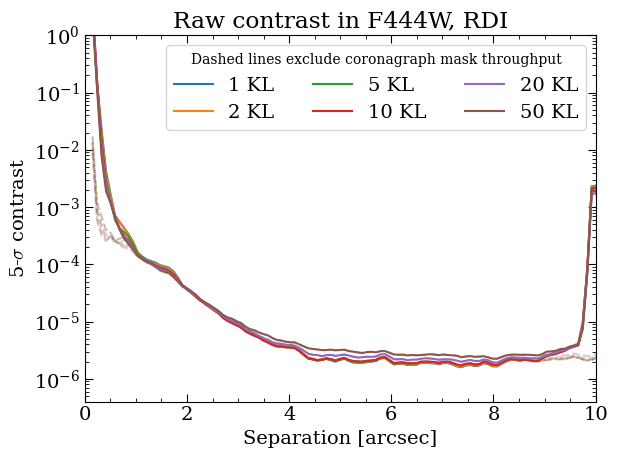

Contrast results and plots saved to data_nircam_twhya/rawcon/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy, data_nircam_twhya/rawcon/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy


In [ ]:
# Compute raw contrast.
analysistools.raw_contrast(
    star_photometry_vot,  # Stellar photometry.
    spectral_type=star_spectral_type,  # Spectral type.
    # [RA offset (arcsec), Dec offset (arcsec), mask radius (lambda/D)].
    subdir='rawcon')

In [ ]:
from astropy.io import fits
# print out the header of data_nircam_twhya/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
# Define the path to the FITS file
fits_file = 'data_nircam_twhya/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits'
# Open the FITS file
with fits.open(fits_file) as hdul:
    # Print the header of the first HDU
    for i in hdul[0].header:
        print(f"{i}: {hdul[0].header[i]}")

SIMPLE: True
BITPIX: -32
NAXIS: 3
NAXIS1: 480
NAXIS2: 480
NAXIS3: 6
EXTEND: True
DRPNFILE: 32
FILE_0: jw01179005001_03107_00001_nrcalong_calints.fits_INT1.fits
FILE_1: jw01179005001_03107_00001_nrcalong_calints.fits_INT10.fits
FILE_2: jw01179005001_03107_00001_nrcalong_calints.fits_INT11.fits
FILE_3: jw01179005001_03107_00001_nrcalong_calints.fits_INT12.fits
FILE_4: jw01179005001_03107_00001_nrcalong_calints.fits_INT13.fits
FILE_5: jw01179005001_03107_00001_nrcalong_calints.fits_INT14.fits
FILE_6: jw01179005001_03107_00001_nrcalong_calints.fits_INT15.fits
FILE_7: jw01179005001_03107_00001_nrcalong_calints.fits_INT16.fits
FILE_8: jw01179005001_03107_00001_nrcalong_calints.fits_INT2.fits
FILE_9: jw01179005001_03107_00001_nrcalong_calints.fits_INT3.fits
FILE_10: jw01179005001_03107_00001_nrcalong_calints.fits_INT4.fits
FILE_11: jw01179005001_03107_00001_nrcalong_calints.fits_INT5.fits
FILE_12: jw01179005001_03107_00001_nrcalong_calints.fits_INT6.fits
FILE_13: jw01179005001_03107_00001_nrc

/tmp/ipykernel_2240664/1379355111.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend() # Add legend to display circle label


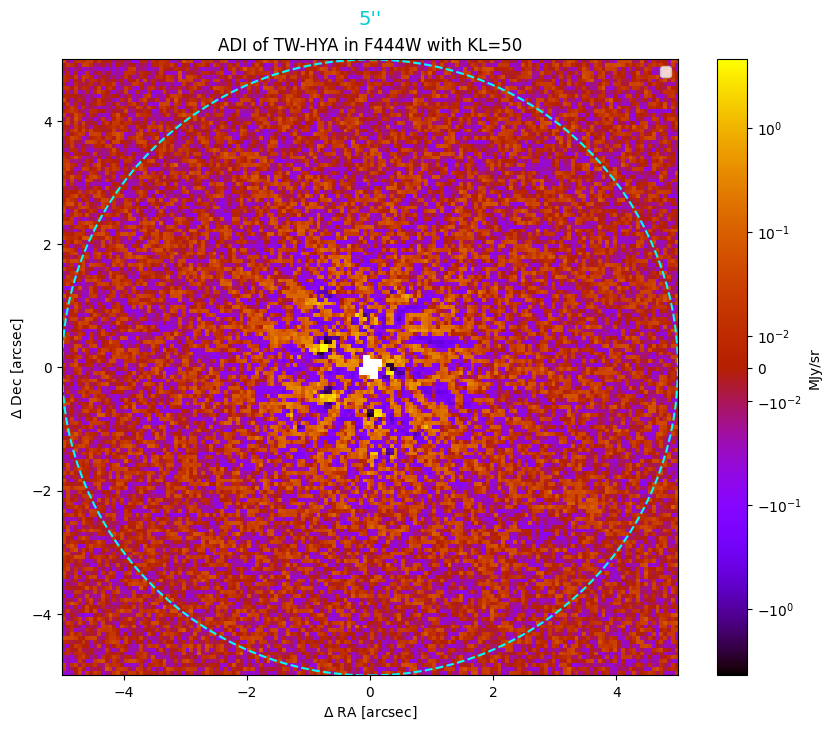

In [ ]:
# Plot saved in data_nircam_twhya/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import numpy as np
import matplotlib.patches as patches # Added for the circle
from matplotlib.colors import SymLogNorm # Import SymLogNorm

# --- Zoom Configuration ---
# Set to a list like [-2, 2] to zoom, or None to disable zoom for that axis.
zoom_x_arcsec = [-5, 5]  # Example: [-5, 5]
zoom_y_arcsec = [-5, 5]  # Example: [-5, 5]
# --- End Zoom Configuration ---

# Define the path to the FITS file
fits_file = 'data_nircam_twhya/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits'
# Open the FITS file
with fits.open(fits_file) as hdul:
    # Load the data from the primary HDU
    data_cube = hdul[0].data
    header = hdul[0].header

    # Determine which slice to plot (user was plotting data[1], which is index 1)
    slice_index_to_plot = 5
    image_data_to_plot = data_cube[slice_index_to_plot]

    # Get necessary info from header for title and axes
    pixscale = header.get('PIXSCALE')  # arcsec/pixel
    filter_name = header.get('FILTER', 'N/A')
    reduction_mode = header.get('MODE', 'N/A')
    target_name = header.get('TARGPROP', 'N/A')
    # KL modes are stored as KLMODEn. data_cube[0] is KLMODE0, data_cube[1] is KLMODE1, etc.
    kl_mode_key = f'KLMODE{slice_index_to_plot}'
    # Use the value from the header (e.g., KLMODE1: 2 means KL=2)
    kl_mode_value = header.get(kl_mode_key, f'Slice {slice_index_to_plot+1}') 
    bunit = header.get('BUNIT', 'Pixel Value')

    # Image dimensions for the selected slice
    ny, nx = image_data_to_plot.shape

    # Center of the image in pixels (0-indexed from PSFCENTX/Y or calculated if not present)
    center_x_pix = header.get('PSFCENTX', (nx - 1) / 2.0)
    center_y_pix = header.get('PSFCENTY', (ny - 1) / 2.0)
    
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # Determine a suitable linear threshold for SymLogNorm
    linthresh = np.percentile(np.abs(image_data_to_plot[np.isfinite(image_data_to_plot) & (image_data_to_plot != 0)]), 50)
    if linthresh == 0: # Handle cases where percentile might be zero (e.g. mostly zero image)
        linthresh = 1e-5 # A small default positive value
    #linthresh = 0.03
    
    # Determine vmin and vmax for SymLogNorm to cover the data range
    data_min = np.nanmin(image_data_to_plot)
    data_max = np.nanmax(image_data_to_plot)
    #data_min = -10
    #data_max = 10

    if pixscale is not None:
        x_min_arcsec = (-0.5 - center_x_pix) * pixscale
        x_max_arcsec = (nx - 0.5 - center_x_pix) * pixscale
        y_min_arcsec = (-0.5 - center_y_pix) * pixscale # bottom for origin='lower'
        y_max_arcsec = (ny - 0.5 - center_y_pix) * pixscale # top for origin='lower'
        extent_arcsec = [x_min_arcsec, x_max_arcsec, y_min_arcsec, y_max_arcsec]

        plt.imshow(image_data_to_plot, cmap='gnuplot', origin='lower', extent=extent_arcsec, 
                   norm=SymLogNorm(linthresh=linthresh, linscale=0.5, vmin=data_min, vmax=data_max, base=10))
        plt.colorbar(label=bunit)
        
        title_str = f'{reduction_mode} of {target_name} in {filter_name} with KL={kl_mode_value}'
        plt.title(title_str)
        plt.xlabel(r'$\Delta$ RA [arcsec]')
        plt.ylabel(r'$\Delta$ Dec [arcsec]')

        reference_circle_radius = 5  # arcsec
        circle = patches.Circle((0, 0), reference_circle_radius, edgecolor='aqua', facecolor='none', linestyle='--', linewidth=1.5)
        ax.add_patch(circle)
        # add a text label for the circle
        circle_label = f'{reference_circle_radius}\'\''
        ax.text(0, reference_circle_radius + 0.5, circle_label, color='darkturquoise', fontsize=14, ha='center', va='bottom')
        ax.set_aspect('equal', adjustable='box')
        plt.legend() # Add legend to display circle label

        # Apply zoom if specified
        if zoom_x_arcsec is not None:
            ax.set_xlim(zoom_x_arcsec)
        if zoom_y_arcsec is not None:
            ax.set_ylim(zoom_y_arcsec)
    else:
        # Fallback to pixel units if pixscale is not available
        print("Warning: PIXSCALE not found in FITS header. Plotting in pixel units.")
        plt.imshow(image_data_to_plot, cmap='gnuplot', origin='lower',
                   norm=SymLogNorm(linthresh=linthresh, linscale=0.5, vmin=data_min, vmax=data_max, base=10))
        plt.colorbar(label=bunit) 
        title_str = f'{filter_name} - {reduction_mode} - KL={kl_mode_value} (Pixel Units)'
        plt.title(title_str)
        plt.xlabel('X Pixel')
        plt.ylabel('Y Pixel')
        # Note: Zoom in arcseconds is not applicable here as pixscale is missing.

    plt.show()

In [ ]:
target_seps = [1,2,3]  # Separation range for contrast estimation.
target_pas = np.linspace(0, 360, 10).tolist()  # Position angle range for contrast estimation.

#Compute calibrated contrast.
analysistools.calibrate_contrast(
    rawcon_subdir='rawcon', # Directory raw contrasts are saved to.
    # [RA offset (arcsec), Dec offset (arcsec), mask radius (lambda/D)].
    injection_seps=target_seps, # arcsec
    injection_pas=target_pas,  # degrees
    injection_flux_sigma=20,
    # Spacing between injected companion, None = 1 companion per injection+recovery.
    multi_injection_spacing=None,
    use_saved=False,  # Useful for debugging / changing plots / sharing files.
    subdir='calcon')  # Save directory.

[spaceKLIP.analysistools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.psf:INFO]   --> Generating WebbPSF model
[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_twhya/klipsub/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 30 source positions suitable for injection.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_twhya/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 30 source positions suitable for injection.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_twhya/klipsub/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 30 source positions suitable for injection.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]